chebyshev.ipynb was getting too big, so we're starting a new one

In [1]:
from sympy import init_session
init_session()
from mpmath import mpf
%matplotlib inline

IPython console for SymPy 1.0.1.dev (Python 3.5.2-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/dev



Now we try to mechanise the CRAM process

In [2]:
def bisect_roots(expr, bounds, eps=1e-7, division_cutoff=30, solver='bisect', **kwargs):
    """
    Numerically find all the roots of expr in bounds via bisection
    
    division_cutoff is the fraction of bounds to check for roots. 
    One should expect the roots to be no more than |bounds|/division_cutoff apart.
    """
    roots = []
    intervals = [bounds]
    var = expr.free_symbols.pop()
    N = 0
    while intervals:
        N += 1
        #print(intervals)
        b = intervals.pop()
        try:
            root = nsolve(expr, b, solver=solver, **kwargs)
        except ValueError:
            # No root found
            if (b[1] - b[0]) > (bounds[1] - bounds[0])/division_cutoff and sign(expr.evalf(subs={var: b[0]})) == sign(expr.evalf(subs={var: b[1]})):
                # The bisect method will only work if the interval has alternate signs.
                # If not, it will miss 2 roots, so try again with split intervals.
                intervals.append([b[0], (b[0] + b[1])/2])
                intervals.append([(b[0] + b[1])/2, b[1]])
                continue
        else:
            if root not in roots:
                roots.append(root)
                intervals.append([b[0], root - eps])
                intervals.append([root + eps, b[1]])
    
    print(N)
    return sorted(roots)

bisect_roots(sin(x), [-10, 13])

115


[mpf('-9.4247779607693797'),
 mpf('-6.2831853071795865'),
 mpf('-3.1415926535897932'),
 mpf('0.0'),
 mpf('3.1415926535897932'),
 mpf('6.2831853071795865'),
 mpf('9.4247779607693797'),
 mpf('12.566370614359173')]

In [25]:
def nsolve_intervals(expr, bounds, division=30, **kwargs):
    """
    Divide bounds into division intervals and nsolve in each one
    """
    roots = []
    L = bounds[1] - bounds[0]
    for i in range(division):
        interval = [bounds[0] + i*L/division, bounds[0] + (i + 1)*L/division]
        try:
            root = nsolve(expr, interval, solver='bisect', **kwargs)
        except ValueError:
            continue
        else:
            roots.append(root)
            
    return roots
        
#nsolve_intervals(D, [-1, 0.99])

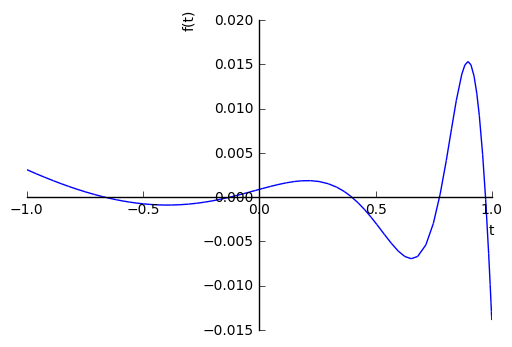

[-1, mpf('-0.39506511254484362'), mpf('0.20691058995491739'), mpf('0.65489012733235114'), mpf('0.89772666518036314'), 0.9999999999999999]
[0.00310345799431899, -0.000894625472960819, 0.00186724750834222, -0.00695054335488386, 0.0153100905720734, -0.0140115018489858]
max - min 0.0293215924210592
epsilon -0.000875207413325278


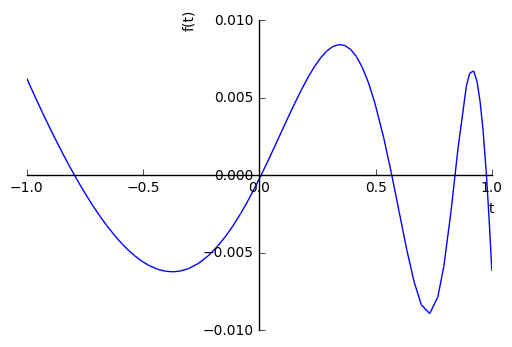

[-1, mpf('-0.374207648153404'), mpf('0.34711423325624722'), mpf('0.72830774622409547'), mpf('0.91600095748638526'), 0.9999999999999999]
[0.00622749048764015, -0.00624556029736911, 0.00841838793392619, -0.00895706975460006, 0.00677549306250030, -0.00622749048764080]
max - min 0.0173754576885262
epsilon -0.00622749048764022


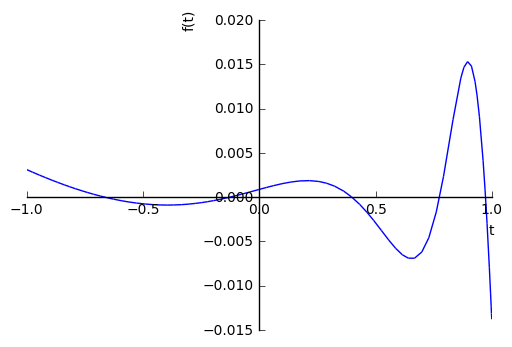

[-1, mpf('-0.39506511254484362'), mpf('0.20691058995491739'), mpf('0.65489012733235114'), mpf('0.89772666518036314'), 0.9999999999999999]
[0.00310345799431899, -0.000894625472960819, 0.00186724750834222, -0.00695054335488386, 0.0153100905720734, -0.0140115018489858]
max - min 0.0293215924210592
epsilon -0.000875207413325278


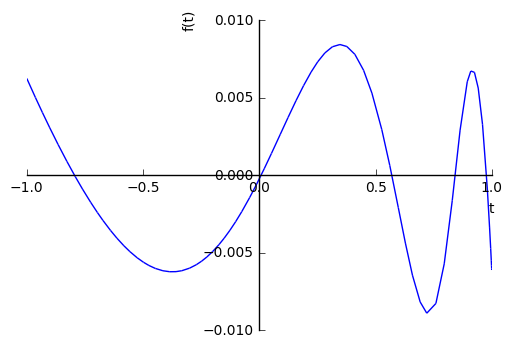

[-1, mpf('-0.374207648153404'), mpf('0.34711423325624722'), mpf('0.72830774622409547'), mpf('0.91600095748638526'), 0.9999999999999999]
[0.00622749048764015, -0.00624556029736911, 0.00841838793392619, -0.00895706975460006, 0.00677549306250030, -0.00622749048764080]
max - min 0.0173754576885262
epsilon -0.00622749048764022


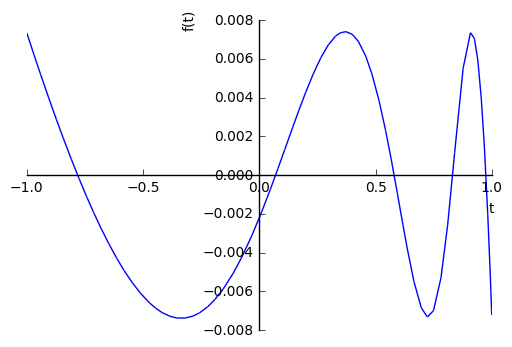

[-1, mpf('-0.33577086592143466'), mpf('0.36934164667940457'), mpf('0.7262939314189323'), mpf('0.9116409078012022'), 0.9999999999999999]
[0.00733103707536709, -0.00739643745596763, 0.00740084952081216, -0.00733348284833222, 0.00736417379946249, -0.00733103707536705]
max - min 0.0147972869767798
epsilon -0.00733103707536685


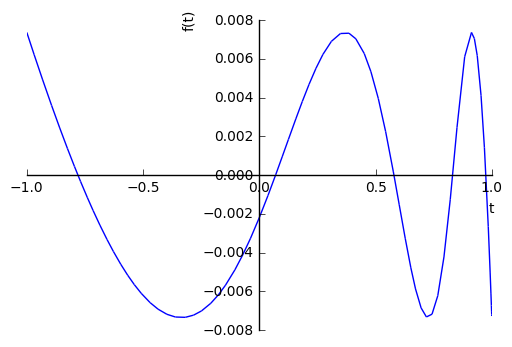

[-1, mpf('-0.33530379944735691'), mpf('0.36899335238225337'), mpf('0.72614009236327307'), mpf('0.91161792764761162'), 0.9999999999999999]
[0.00735866283283215, -0.00735867258325784, 0.00735868049388205, -0.00735867701708351, 0.00735866374448577, -0.00735866283283289]
max - min 0.0147173575109656
epsilon -0.00735866283283211


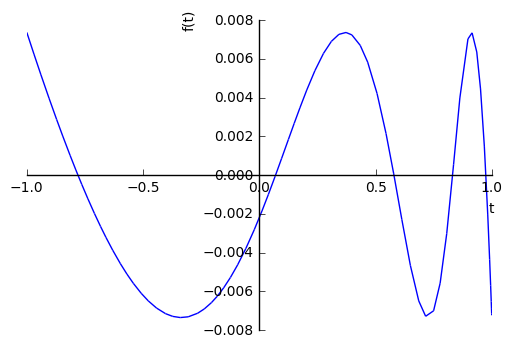

[-1, mpf('-0.33530359100794863'), mpf('0.36899339640310308'), mpf('0.72614004598521826'), mpf('0.91161790093035237'), 0.9999999999999999]
[0.00735867016957992, -0.00735867016958180, 0.00735867016958097, -0.00735867016958067, 0.00735867016958021, -0.00735867016957992]
max - min 0.0147173403391628
epsilon -0.00735867016958001


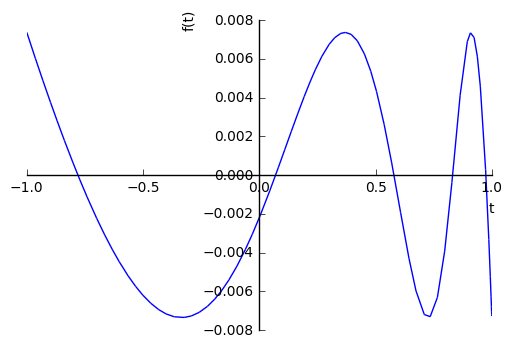

[-1, mpf('-0.33530359100804056'), mpf('0.36899339640312193'), mpf('0.72614004598521038'), mpf('0.91161790093034811'), 0.9999999999999999]
[0.00735867016958014, -0.00735867016957970, 0.00735867016958069, -0.00735867016957910, 0.00735867016958172, -0.00735867016958037]
max - min 0.0147173403391621
epsilon -0.00735867016958023


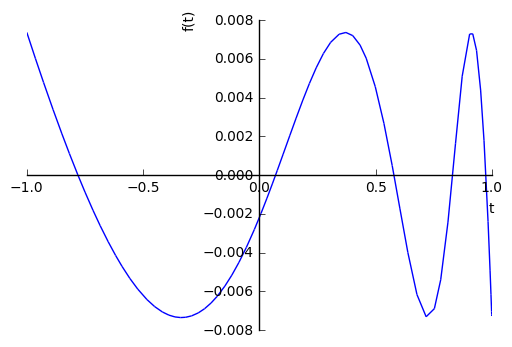

[-1, mpf('-0.33530359100798432'), mpf('0.36899339640311658'), mpf('0.72614004598521971'), mpf('0.91161790093034664'), 0.9999999999999999]
[0.00735867016958069, -0.00735867016958125, 0.00735867016958047, -0.00735867016957912, 0.00735867016958159, -0.00735867016958136]
max - min 0.0147173403391630
epsilon -0.00735867016958094


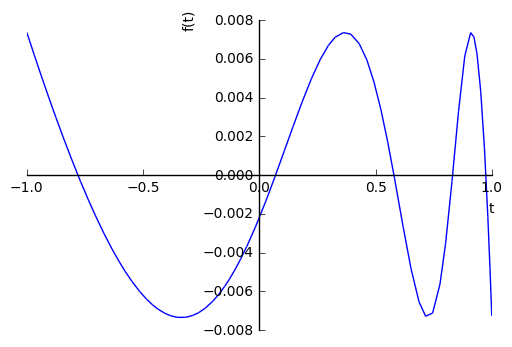

[-1, mpf('-0.33530359100796862'), mpf('0.36899339640309693'), mpf('0.72614004598521842'), mpf('0.91161790093035242'), 0.9999999999999999]
[0.00735867016958103, -0.00735867016958092, 0.00735867016958031, -0.00735867016958199, 0.00735867016957915, -0.00735867016958171]
max - min 0.0147173403391630
epsilon -0.00735867016958098


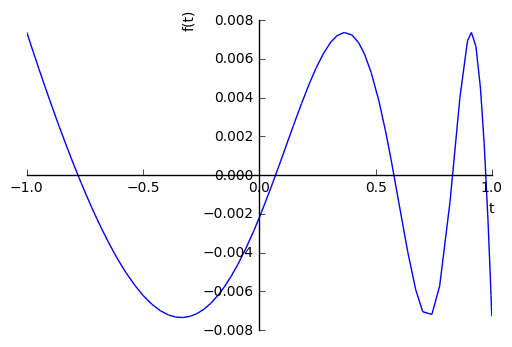

[-1, mpf('-0.33530359100801999'), mpf('0.36899339640312689'), mpf('0.72614004598521155'), mpf('0.91161790093034781'), 0.9999999999999999]
[0.00735867016958014, -0.00735867016958014, 0.00735867016958042, -0.00735867016957931, 0.00735867016958228, -0.00735867016958095]
max - min 0.0147173403391632
epsilon -0.00735867016958028


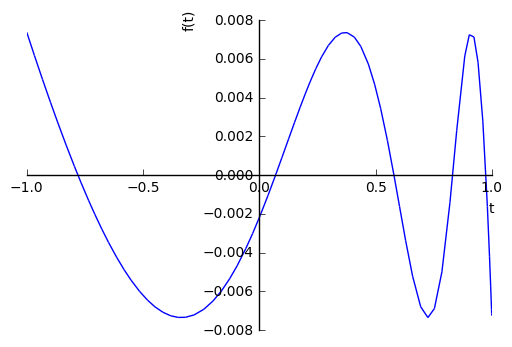

[-1, mpf('-0.33530359100796977'), mpf('0.36899339640309929'), mpf('0.72614004598521576'), mpf('0.91161790093035292'), 0.9999999999999999]
[0.00735867016958058, -0.00735867016958103, 0.00735867016958014, -0.00735867016958234, 0.00735867016957915, -0.00735867016958114]
max - min 0.0147173403391629
epsilon -0.00735867016958064
(0.00421099590689835*t**2 - 0.188333501989268*t + 0.992641329830419)/(0.57224957904838*t**2 + 0.669301542710872*t + 1.0)


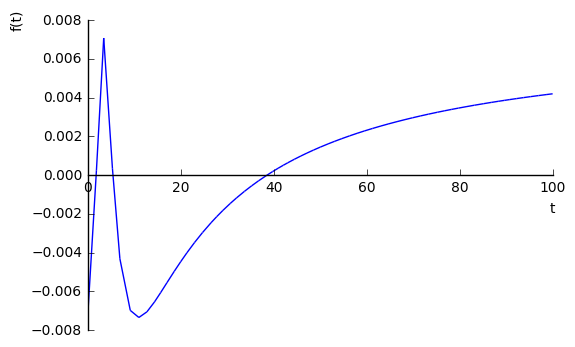

In [87]:
from sympy.utilities.decorator import conserve_mpmath_dps

@conserve_mpmath_dps
def CRAM_exp2(loops=2):
    import mpmath
#    mpmath.mp.dps = 128

    epsilon = symbols("epsilon")
    p0, p1, p2, q1, q2 = symbols("p0, p1, p2, q1, q2")
    i = symbols("i")
    
    r = (p0 + p1*t + p2*t**2)/(1 + q1*t + q2*t**2)
    E = exp(-(-t - 1)/(2*t - 2)) - r
    expr = E + (-1)**i*epsilon
    expr = expr*(1 + q1*t + q2*t**2)
    expr = simplify(expr)

    points = [chebyshevt_root(7, 6 - j) for j in range(1, 7)]
    for _ in range(loops):
        system = Tuple(*[expr.subs({i: j, t: points[j]}) for j in range(6)])
#        system = system + Tuple(limit(expr.subs({i: 5}), t, points[5], '-'))
#        print(system)
        sol = dict(zip([p0, p1, p2, q1, q2, epsilon], nsolve(system, [p0, p1, p2, q1, q2, epsilon], [1, 1, 1, 1, 1, 0])))
        D = diff(E.subs(sol), t)
        plot(E.subs(sol), (t, -1, 1))
        # More 9's here means more accuracy, but we can't use 1 because of the singularity
        points = [-1, *nsolve_intervals(D, [-1, 0.99]), 0.9999999999999999]
        print(points)
        Evals = [E.subs(sol).subs(t, point) for point in points]# + [limit(E.subs(sol), t, 1, '-')]
        print(Evals)
        print('max - min', max(Evals) - min(Evals))
        print('epsilon', sol[epsilon])
        assert len(points) == 6
    
    n, d = together(r.subs(sol).subs(t, (2*t - 1)/(2*t + 1))).as_numer_denom() # simplify/cancel here will add degree to the numerator and denominator
    rat_func = (Poly(n)/Poly(d).TC())/(Poly(d)/Poly(d).TC())
    return rat_func.subs(sol)

D = CRAM_exp2()

rat_func = CRAM_exp2(10)
print(rat_func)
plot(rat_func - exp(-t), (t, 0, 100))

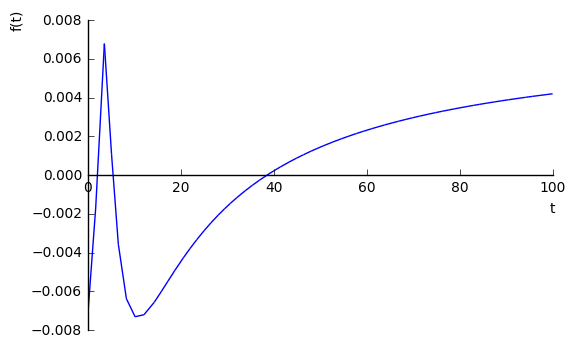

In [85]:
correct_rat_func2 = (9.92641e-1 + -1.88332e-1*t + 4.21096e-3*t**2)/(1 + 6.69295e-1*t + 5.72258e-1*t**2)
plot(correct_rat_func2 - exp(-t), (t, 0, 100))

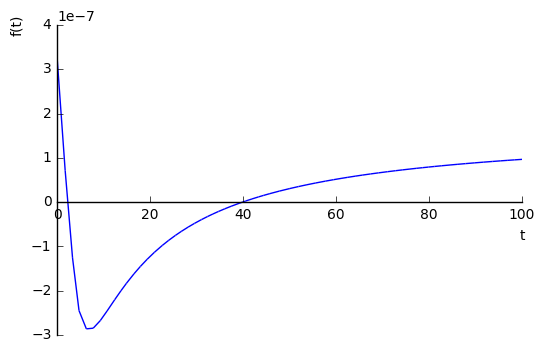

In [86]:
plot(rat_func - correct_rat_func2, (t, 0, 100))

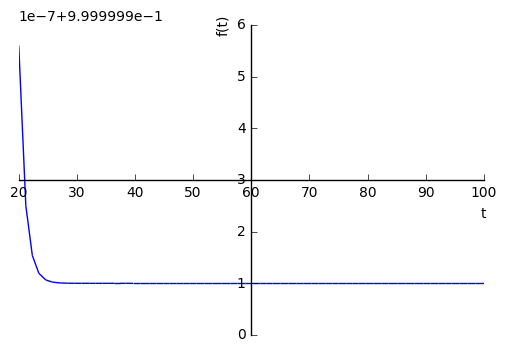

In [41]:
plot((correct_rat_func2 - exp(-t))/correct_rat_func2, (t, 20, 100))

In [5]:
nsolve(D, (-1, -0.39506511254484362 - 1e-20), solver='bisect', tol=1e-20)

mpf('-0.39506511254488194')

In [6]:
#import mpmath
#mpmath.findroot?

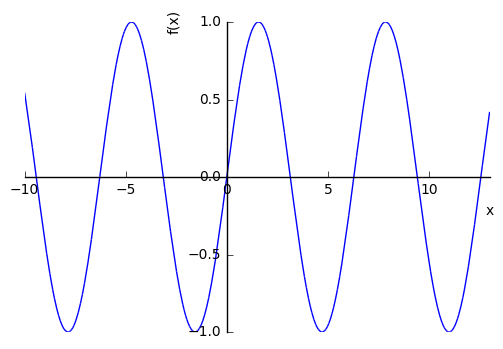

In [7]:
plot(sin(x), (x, -10, 13))

In [8]:
nsolve(sin(x), [-10, -0.1], solver='bisect')

mpf('-3.1415926535897932')

In [9]:
bisect_roots(D, [-1, 0.9], solver='bisect')

109


[mpf('-0.39506511254488194'),
 mpf('0.20691058995492143'),
 mpf('0.65489012733236148'),
 mpf('0.89772666518036129'),
 mpf('0.89772676518036132'),
 mpf('0.89772676518036132'),
 mpf('0.89772686518036127'),
 mpf('0.89772686518036127'),
 mpf('0.89772696518036121'),
 mpf('0.89772696518036121'),
 mpf('0.89772706518036116'),
 mpf('0.89772706518036116')]

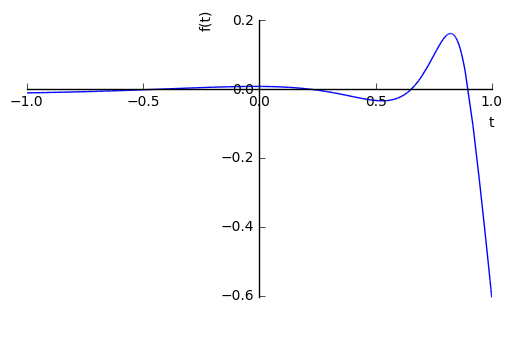

In [10]:
plot(D, (t, -1, 1))

In [11]:
nsolve(D, [mpf('0.2069106899549174') + 1e-4, 0.999], solver='ridder')

ValueError: Could not find root within given tolerance. (1.065e-06 > 2.1684e-19)
Try another starting point or tweak arguments.

In [ ]:
intervals = [[i/30, (i+1)/30] for i in range(-30, 29)]

In [ ]:
def catch_ValueError(f):
    try:
        return f()
    except ValueError:
        pass

In [ ]:
[catch_ValueError(lambda: nsolve(D, b, solver='bisect')) for b in intervals]

In [ ]:
sin(x).evalf(subs={x: mpf('9.9999999999999995e-8')})

In [12]:
nsolve(D, (-1, 0), solver='bisect')

mpf('-0.39506511254488194')

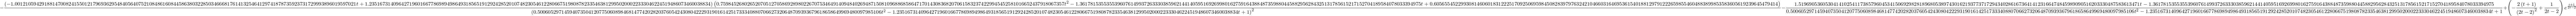

In [13]:
D

In [34]:
import mpmath
try:
    mpmath.mp.dps = 128
    print(nsolve(D, (-1, 0), solver='bisect', maxsteps=300))
finally:
    mpmath.mp.dps = 15

ValueError: Could not find root within given tolerance. (1.38725 > 1.40884e-132)
Try another starting point or tweak arguments.

In [30]:
chebyshevt(2, x)